In [214]:
using DifferentialEquations
using LinearAlgebra
using Plots

include("../model/Plant.jl")

Main.Plant

In [215]:
p = Plant.Params()
state = Plant.State()
u0 = [state.x, state.y, state.n, state.h, state.Ca, state.V, state.Isyn]
tspan = (0, 1e6)
prob = ODEProblem(Plant.melibeNew!, u0, tspan, p)
sol = solve(prob);

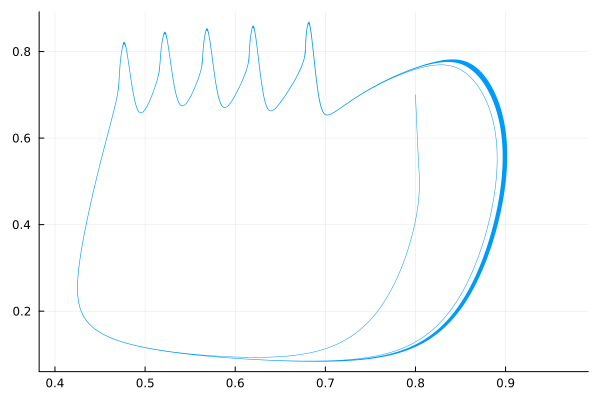

In [216]:
plot(sol, idxs=(5, 1), lw=0.5, legend=false, dpi=1000)

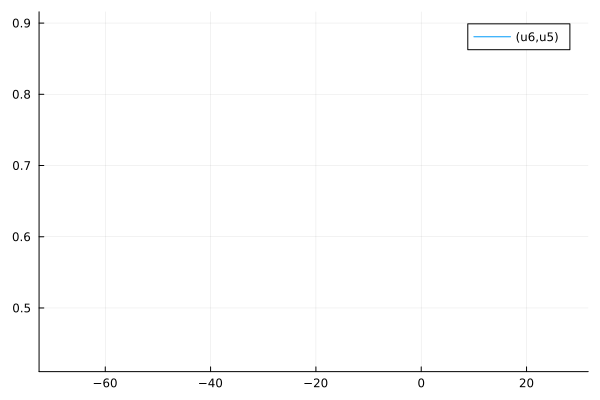

In [217]:
plot(sol, idxs=(6, 5), lw=3e-2)

In [274]:
function countSpikes(p::Plant.Params, state::Plant.State)
    u0 = [state.x, state.y, state.n, state.h, state.Ca, state.V, state.Isyn]
    tspan = (0, 1e6)
    prob = ODEProblem(Plant.melibeNew!, u0, tspan, p)
    sol = solve(prob)

    x_threshold = 0.5 # Clearly the correct threshold is actually obtained by counting the winding number about the equilibrium.

    # Obtain burst reset times.
    resets = []
    for i in 2:length(sol)
        if sol[i-1][1] < x_threshold < sol[i][1]
            push!(resets, i)
        end
    end

    #print("$(length(resets)) burst resets observed.")

    V_threshold = 0.0

    # Obtain spike counts per burst.
    spike_counts = []
    for i in 1:length(resets)-1
        spike_count = 0
        for j in resets[i]:resets[i+1]
            if sol[j-1][6] < V_threshold < sol[j][6]
                spike_count += 1
            end
        end
        push!(spike_counts, spike_count)
    end

    return spike_counts
end

countSpikes (generic function with 3 methods)

In [219]:
function transitionMap(spike_counts)
    plt = scatter(1, markeralpha=0.2, legend=false)
    for i in 1:length(spike_counts)-1
        push!(plt, (spike_counts[i], spike_counts[i+1]))
    end
    return plt
end

transitionMap (generic function with 3 methods)

99 burst resets observed.

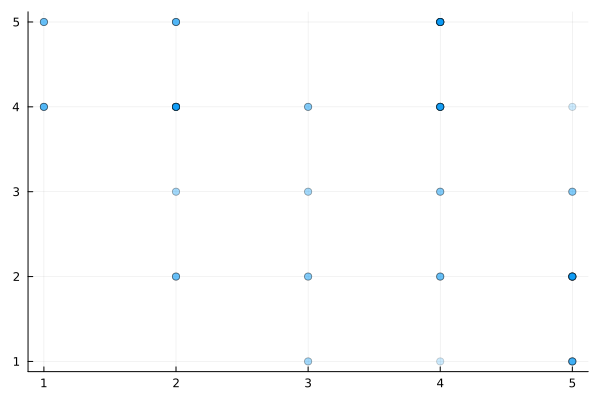

In [220]:
p = Plant.Params(
    Δx = -2.0
)

transitionMap(countSpikes(p, state))

In [316]:
function markovChain(spike_counts)
    if length(spike_counts) == 0
        return zeros(0, 0)
    end
    size = max(spike_counts...)
    if size == 0
        return zeros(0, 0)
    end
    rows = []
    for i in 0:size
        row = zeros(size+1)
        for j in 1:length(spike_counts)-1
            if spike_counts[j] == i
                row[spike_counts[j+1]+1] += 1
            end
        end
        if sum(row) == 0
            push!(rows, row)
        else
            push!(rows, row/sum(row))
        end
    end
    return reduce(vcat, transpose.(rows))
end

markovChain (generic function with 1 method)

In [317]:
markovChain(countSpikes(p, state))

2×2 Matrix{Float64}:
 0.964286  0.0357143
 1.0       0.0

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/carter/.julia/packages/SciMLBase/wEAy7/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/carter/.julia/packages/SciMLBase/wEAy7/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/carter/.julia/packages/SciMLBase/wEAy7/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/carter/.julia/packages/SciMLBase/wEAy7/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/carter/.julia/packages/SciMLBase/wEAy7/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/carter/.julia/packages/SciMLBase/wEAy7/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/carter/.julia/packages/SciMLBase/wEAy7/src/integrator_interface.jl:523
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/carter/

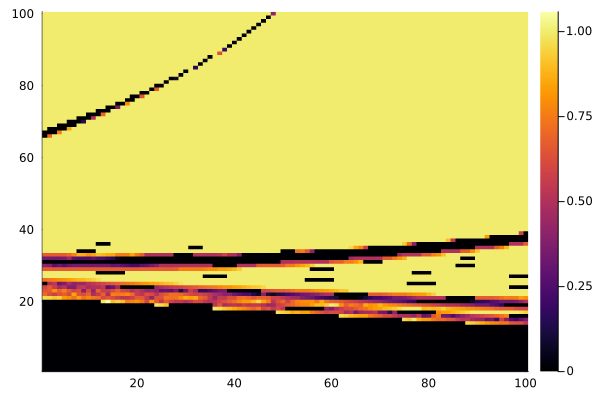

In [322]:
ΔCa_length = 100
Δx_length = 100

range_ΔCa = range(22.0, 31.0, length=ΔCa_length)
range_Δx = range(-3.0, -1.0, length=Δx_length)
complexities = []

for ΔCa in range_ΔCa
    for Δx in range_Δx
        p = Plant.Params(
            ΔCa = ΔCa,
            Δx = Δx
        )
        push!(complexities, tr(markovChain(countSpikes(p, state))))
    end
end

heatmap(reshape(complexities, (Δx_length, ΔCa_length)))